In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import gc
import numpy as np
import seaborn as sns
from sklearn.preprocessing import normalize
import textstat
import matplotlib
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [2]:
def SchoolPart(df):
    conditions = [
        df['Flesch RE'] >= 100,
        (df['Flesch RE'] < 100) & (df['Flesch RE'] >= 90),
        (df['Flesch RE'] < 90) & (df['Flesch RE'] >= 80),
        (df['Flesch RE'] < 80) & (df['Flesch RE'] >= 70),
        (df['Flesch RE'] < 70) & (df['Flesch RE'] >= 60),
        (df['Flesch RE'] < 60) & (df['Flesch RE'] >= 50),
        (df['Flesch RE'] < 50) & (df['Flesch RE'] >= 30),
        (df['Flesch RE'] < 30) & (df['Flesch RE'] >= 0),
        df['Flesch RE'] < 0]
    choices = ['4th or Below', '5th', '6th', '7th', '8th or 9th', '10th - 12th', 'College', 'College Graduate', 'Post Graduate Study']
    df['SchoolYearRead'] = np.select(conditions, choices, default='NULL')
    df['4th or Below'] = np.where(df['SchoolYearRead'] == '4th or Below', 1, 0)
    df['5th'] = np.where(df['SchoolYearRead'] == '5th', 1, 0)
    df['6th'] = np.where(df['SchoolYearRead'] == '6th', 1, 0)
    df['7th'] = np.where(df['SchoolYearRead'] == '7th', 1, 0)
    df['8th or 9th'] = np.where(df['SchoolYearRead'] == '8th or 9th', 1, 0)
    df['10th - 12th'] = np.where(df['SchoolYearRead'] == '10th - 12th', 1, 0)
    df['College'] = np.where(df['SchoolYearRead'] == 'College', 1, 0)
    df['College Graduate'] = np.where(df['SchoolYearRead'] == 'College Graduate', 1, 0)
    df['Post Graduate Study'] = np.where(df['SchoolYearRead'] == 'Post Graduate Study', 1, 0)
    df = df.drop(columns = ['SchoolYearRead'])
    conditions = [
        df['Flesch RE'] >= 90,
        (df['Flesch RE'] < 90) & (df['Flesch RE'] >= 60),
        (df['Flesch RE'] < 60) & (df['Flesch RE'] >= 30),
        df['Flesch RE'] < 30]
    choices = ['Elementary and Below', 'Middle', 'High+', 'College Graduate+']
    df['SchoolGroupRead'] = np.select(conditions, choices, default='NULL')
    df['Elementary and Below'] = np.where(df['SchoolGroupRead'] == 'Elementary and Below', 1, 0)
    df['Middle School'] = np.where(df['SchoolGroupRead'] == 'Middle', 1, 0)
    df['High+'] = np.where(df['SchoolGroupRead'] == 'High+', 1, 0)
    df['College Graduate+'] = np.where(df['SchoolGroupRead'] == 'College Graduate+', 1, 0)
    df = df.drop(columns = ['SchoolGroupRead'])
    return df

In [3]:
df = pd.read_pickle('Full_Read_Dataset.pkl')
df = df.drop(columns = ['SchoolYearRead', 'SchoolGroupRead'])
df = SchoolPart(df)
df['Engage_log'] = np.log(df['Engagement_Rate'])

In [4]:
df.head()

,PageName,PostID,PostTime,Height,Width,Followers,Comments,Likes,Flesch RE,Engagement_Rate,...,8th or 9th,10th - 12th,College,College Graduate,Post Graduate Study,Elementary and Below,Middle School,High+,College Graduate+,Engage_log
0,hoteltonight,2001676146483242968,2019-03-17T16:00:13.000Z,1080,1080,107338,10,263,37.960294,0.254337,...,0,0,1,0,0,0,0,1,0,-1.369096
1,hoteltonight,2000951577464146177,2019-03-16T16:00:37.000Z,1350,1080,107338,10,453,54.722895,0.431348,...,0,1,0,0,0,0,0,1,0,-0.840841
2,hoteltonight,2000166467894605804,2019-03-15T14:00:45.000Z,1350,1080,107338,11,568,63.695000,0.539418,...,1,0,0,0,0,0,1,0,0,-0.617265
3,hoteltonight,1999665368355860144,2019-03-14T21:25:09.000Z,1318,1080,107338,19,617,63.865000,0.592521,...,1,0,0,0,0,0,1,0,0,-0.523369
4,hoteltonight,1999441033900857703,2019-03-14T13:59:26.000Z,1350,1080,107338,20,774,84.450000,0.739719,...,0,0,0,0,0,0,1,0,0,-0.301484


In [ ]:
def Random_Forest(df):
    temp = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
    X = temp._get_numeric_data()
    X = X.drop(columns = ['engagement_rate'])
    X = X.drop(columns = ['Followers'])
    X = X.drop(columns = ['Likes'])
    X = X.drop(columns = ['Comments'])
    X = X.drop(columns = ['minuteofpost'])
    y = temp['engagement_rate']
    del [[temp]]
    gc.collect()
    regr = RandomForestRegressor(n_estimators = 100, min_samples_leaf=50, max_features=0.5)
    regr.fit(X, y)
    return list(X), regr.feature_importances_ 

In [ ]:
Features, Importances = Random_Forest(df)

In [ ]:
top_20_idx = np.argsort(Importances)[-20:]
top_20_val = [Importances[i] for i in top_20_idx]
top_20_feats = [Features[i] for i in top_20_idx]
print(top_20_feats, top_20_val)

In [ ]:
def heatmap(df):
    val = df.values
    normdf = normalize(val[:,[8,6,7,5,11]], axis=0, norm='max')
    covar = np.corrcoef(normdf.transpose())
    col = ['Flesch', 'Comments', 'Likes', 'Followers', 'Engagement']
    fig, ax = plt.subplots()
    sns.heatmap(covar, annot=True, fmt=".2f")
    ax.set_xticklabels(col)
    ax.set_yticklabels(col)
    ax.set_title("Normalized Readability Correlation Data")
    fig.set_size_inches(11.7, 8.27)
    fig.savefig('readheatmap.png')

In [ ]:
def box_plots(df):
    sns.set(style="whitegrid")
    ax = sns.boxplot(x="SchoolGroupRead", y="Engagement_Rate", data=df)

In [ ]:
def outlier_boxplot(df):
    coll = df.loc[df['SchoolGroupRead'] == 'High'] #Select the rows with ___ level captions
    mean = np.mean(coll['Engagement_Rate'], axis=0) #Get the mean
    sd = np.std(coll['Engagement_Rate'], axis=0) #Get the standard deviation
    final_list = [x for x in coll['Engagement_Rate'] if (x > mean - 2 * sd)]
    final_list = [x for x in final_list if (x < mean + 2 * sd)]
    ax = sns.boxplot(data = final_list)

In [ ]:
def Average_by_School(df):
    coll = df.loc[df['SchoolGroupRead'] == 'College Graduate'] #Select the rows with ___ level captions
    mean = np.mean(coll['Engagement_Rate'], axis=0) #Get the mean
    print(mean)

In [ ]:
Average_by_School(df)

In [ ]:
df.loc[df['SchoolGroupRead'] == 'Post Graduate Studies']

In [5]:
def SchoolGroup_heatmap(df): #FIX!!
    df1 = df.iloc[:,[23,19,20,21,22]]
    df1 = df1[np.isfinite(df1).all(1)]
    val = df1.values
    normdf = normalize(val[:,[1,2,3,4,0]], axis=0, norm='max')
    covar = np.corrcoef(normdf.transpose())
    col = ['Elementary and Below', 'Middle School', 'High+', 'College Graduate+', 'Engagement']
    fig, ax = plt.subplots()
    sns.heatmap(covar, annot=True, fmt=".2f")
    ax.set_xticklabels(col)
    ax.set_yticklabels(col)
    ax.set_title("School Group Correlation")
    fig.set_size_inches(11.7, 8.27)

In [11]:
def SchoolYear_heatmap(df): #FIX!!
    df1 = df.iloc[:,[23,10,11,12,13,14,15,16,17,18]]
    df1 = df1[np.isfinite(df1).all(1)]
    val = df1.values
    normdf = normalize(val[:,[1,2,3,4,5,6,7,8,9,0]], axis=0, norm='max')
    covar = np.corrcoef(normdf.transpose())
    col = ['4th and Below', '5th', '6th', '7th', '8th or 9th', '10th - 12th', 'College', 'College Graduate', 'Post Graduate Study' 'Engagement']
    fig, ax = plt.subplots()
    sns.heatmap(covar, annot=True, fmt=".2f")
    ax.set_xticklabels(col)
    ax.set_yticklabels(col)
    ax.set_title("School Year Correlation")
    fig.set_size_inches(11.7, 8.27)

In [7]:
def Read_heatmap(df): #FIX!!
    df1 = df.iloc[:,[23,8]]
    df1 = df1[np.isfinite(df1).all(1)]
    val = df1.values
    normdf = normalize(val[:,[1,0]], axis=0, norm='max')
    covar = np.corrcoef(normdf.transpose())
    col = ['Flesch', 'Comments', 'Likes', 'Followers', 'Engagement']
    fig, ax = plt.subplots()
    sns.heatmap(covar, annot=True, fmt=".2f")
    ax.set_xticklabels(col)
    ax.set_yticklabels(col)
    ax.set_title("Readability Correlation")
    fig.set_size_inches(11.7, 8.27)

In [8]:
print(df.columns.values)

['PageName' 'PostID' 'PostTime' 'Height' 'Width' 'Followers' 'Comments'
 'Likes' 'Flesch RE' 'Engagement_Rate' '4th or Below' '5th' '6th' '7th'
 '8th or 9th' '10th - 12th' 'College' 'College Graduate'
 'Post Graduate Study' 'Elementary and Below' 'Middle School' 'High+'
 'College Graduate+' 'Engage_log']


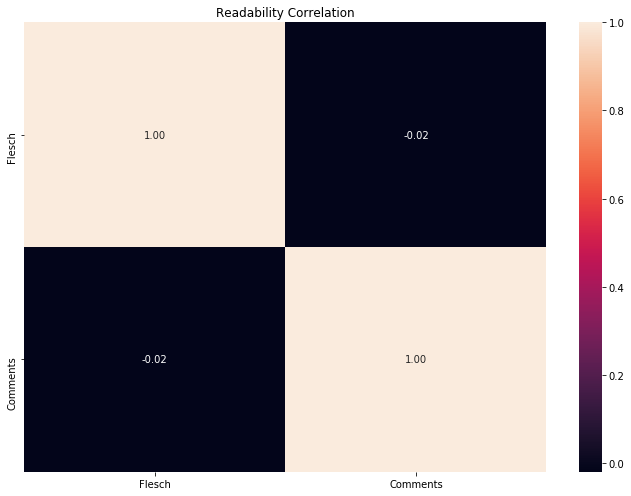

In [13]:
Read_heatmap(df)

In [18]:
df = df.drop(columns = ['Engagement_Rate'])
df.head()

,Flesch RE,4th or Below,5th,6th,7th,8th or 9th,10th - 12th,College,College Graduate,Post Graduate Study,Elementary and Below,Middle School,High+,College Graduate+,Engage_log
0,37.960294,0,0,0,0,0,0,1,0,0,0,0,1,0,-1.369096
1,54.722895,0,0,0,0,0,1,0,0,0,0,0,1,0,-0.840841
2,63.695000,0,0,0,0,1,0,0,0,0,0,1,0,0,-0.617265
3,63.865000,0,0,0,0,1,0,0,0,0,0,1,0,0,-0.523369
4,84.450000,0,0,1,0,0,0,0,0,0,0,1,0,0,-0.301484


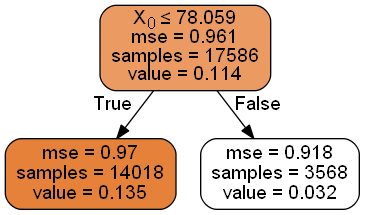

In [19]:
df = df[np.isfinite(df).all(1)]
y = df['Engage_log']
X = df.loc[:, df.columns !='Engage_log']
clf = tree.DecisionTreeRegressor(max_depth=1)
clf = clf.fit(X, y)
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())